# Facial Emotion Recognition | VGG16-VGG19-EfficientNet_B3-Custom_CNN-SVM-Lightgbm-XGBoost Models - FER2013 & CK+ Dataset

![](https://www.researchgate.net/publication/349055345/figure/fig3/AS:987834383085568@1612529478973/FER-2013-sample-images-for-facial-emotion-recognition.jpg)

## FER2013 Dataset

The FER2013 dataset is a widely used dataset for facial emotion recognition. It contains 35,887 grayscale facial images of size 48×48 pixels, categorized into 7 different emotions:

- Anger
- Disgust
- Fear
- Happiness
- Neutral
- Sadness
- Surprise

This dataset is commonly used to train deep learning and machine learning models for automatic facial expression classification.
### Deep Learning Models
1. VGG16 & VGG19

- VGG16 and VGG19 are convolutional neural network (CNN) architectures known for their deep feature extraction capabilities.
- VGG16 consists of 16 layers, while VGG19 has 19 layers, both with multiple convolutional layers followed by fully connected layers.
- Transfer learning can be applied using pre-trained weights (ImageNet) to leverage existing knowledge for facial expression classification.
- The final fully connected layer is replaced with a 7-class classifier to match the FER2013 dataset.
- Training involves multiple epochs to fine-tune the model for better accuracy.

2. EfficientNet_B3

- EfficientNet_B3 is a modern CNN architecture optimized for performance and efficiency.
- It utilizes compound scaling to balance width, depth, and resolution of the network.
- Pre-trained weights from ImageNet can be fine-tuned on the FER2013 dataset.
- EfficientNet_B3 often provides better accuracy with fewer parameters compared to VGG models.

3. Custom CNN

- A custom CNN architecture is designed specifically for facial emotion recognition.
- It includes convolutional, pooling, and fully connected layers optimized for the FER2013 dataset.
- The number of filters, kernel sizes, and activation functions are chosen based on dataset characteristics.
- Batch normalization and dropout are used to prevent overfitting.

### Machine Learning Models
4. Support Vector Machine (SVM)

    - SVM is a powerful non-deep learning model used for classification.
    - Features are extracted from pre-trained CNN models (e.g., VGG19, EfficientNet_B3), and SVM is trained on these features.
    - The Radial Basis Function (RBF) kernel is often used to handle non-linearity in facial expressions.

5. LightGBM

    - LightGBM is a gradient boosting framework optimized for speed and efficiency.
    - It is trained on feature vectors extracted from CNN models or manually engineered features.
    - LightGBM can handle imbalanced datasets well by using techniques like Balanced Bagging and Weighted Loss.

6. XGBoost

    - XGBoost is an optimized gradient boosting algorithm that performs well on structured data.
    - Like LightGBM, it uses CNN-extracted features or handcrafted features for classification.
    - XGBoost is known for handling missing values and reducing overfitting through regularization.


## Importing Libraries

In [1]:
import math
import numpy as np
import pandas as pd

import cv2
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical
import time


## Load And Anylyse Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_dataset = '/content/drive/MyDrive/dataset/fer2013.csv'
df = pd.read_csv(path_dataset)
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:

ck_path_dataset = '/content/drive/MyDrive/dataset/ck.csv'
ck_df = pd.read_csv(ck_path_dataset)
# remove all emotion with label 7
ck_df = ck_df[ck_df['emotion'] != 7]
print(ck_df.shape)
ck_df.head()


(902, 3)


,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


In [5]:
# emotions unique values
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [6]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df.emotion.value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


In [7]:
# make sure that image size is 48x48 pixels
math.sqrt(len(df.pixels[0].split(' '))) #should be 48

48.0

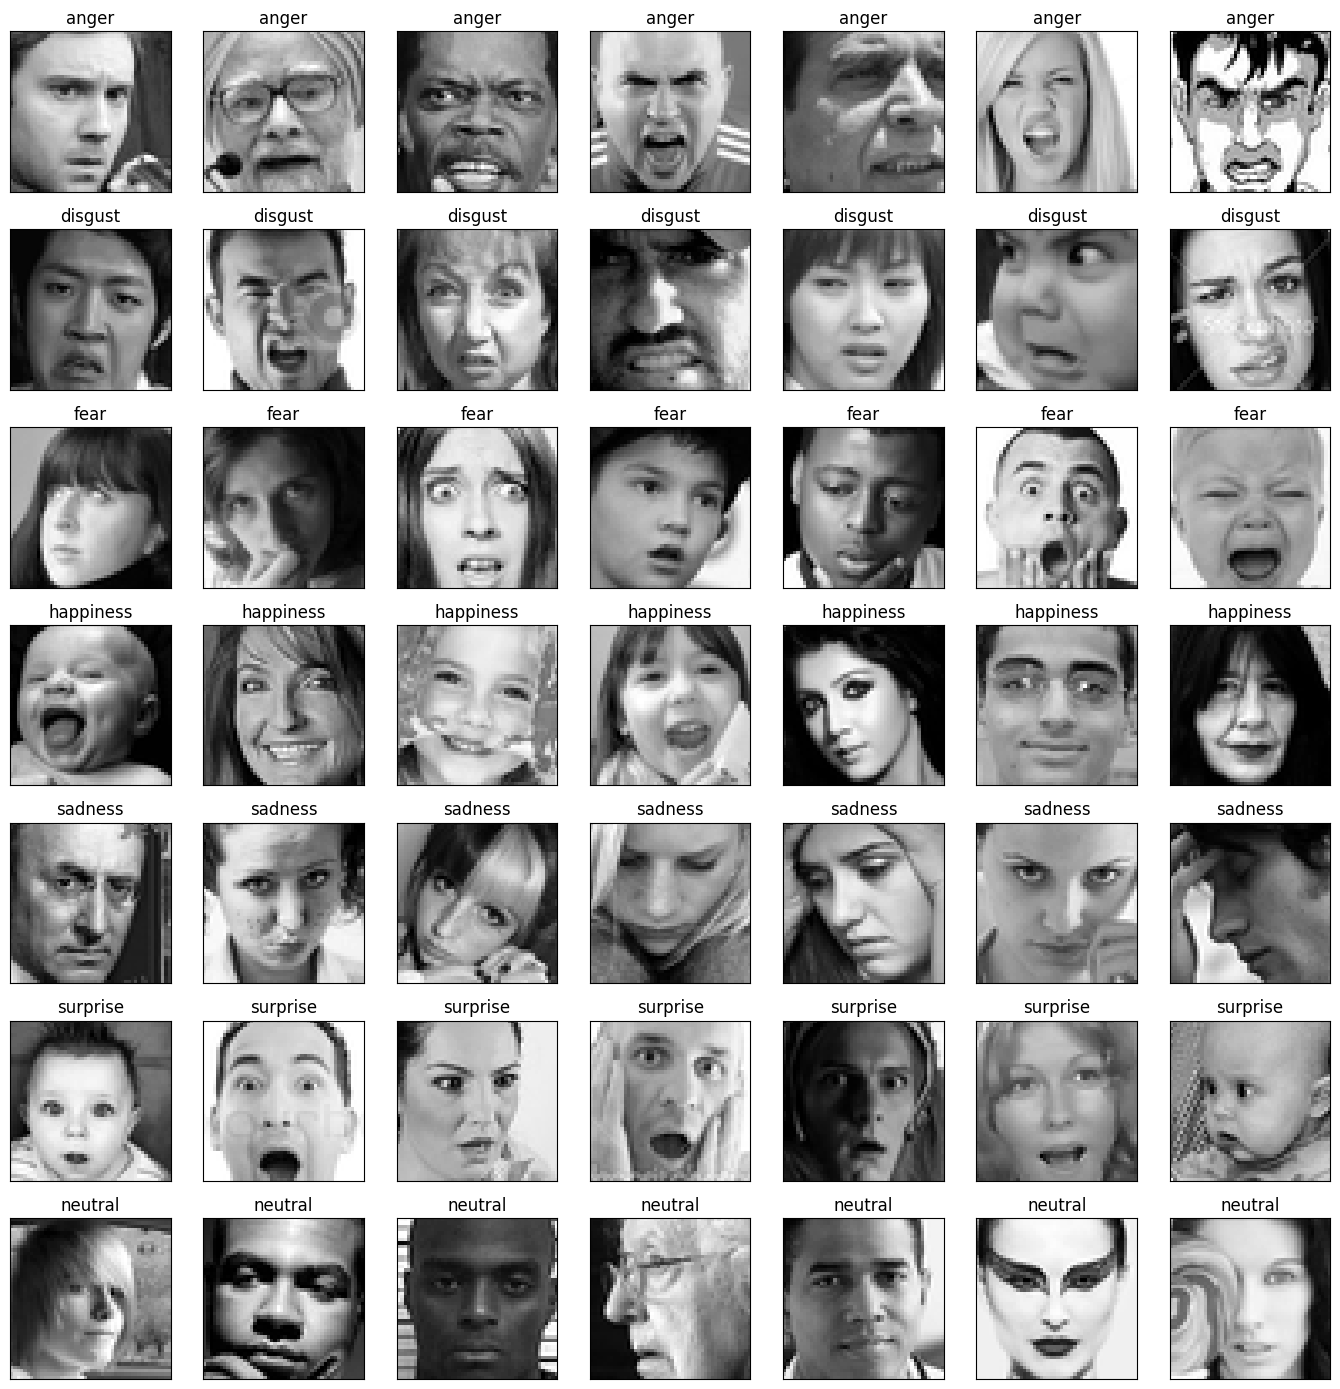

In [8]:
# display some images
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [9]:
# First, check if GPU is available and configure TensorFlow to use it
def setup_gpu():
    """Configure TensorFlow to use GPU optimally"""

    # Check if GPU is available
    gpus = tf.config.list_physical_devices('GPU')

    if gpus:
        try:
            print(f"Found {len(gpus)} GPU(s)")
            for gpu in gpus:
                print(f"Name: {gpu.name}, Type: {gpu.device_type}")

            # Configure TensorFlow to use memory growth
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Set visible devices if you have multiple GPUs and want to use specific ones
            # tf.config.set_visible_devices(gpus[0], 'GPU')

            # Use mixed precision for faster training
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print("Using mixed precision policy:", policy.name)

            return True
        except RuntimeError as e:
            print(f"GPU error: {e}")
            return False
    else:
        print("No GPU found. Using CPU.")
        return False



## Preprocessing Data

In [10]:
def load_and_preprocess_data(path, source_type='csv'):
    """
    Load and preprocess image data for emotion recognition.

    Parameters:
    path (str): Path to either a CSV file or a directory containing image folders
    source_type (str): 'csv' or 'folder' to specify the data source type

    Returns:
    tuple: (image features array, one-hot encoded labels)
    """
    if source_type == 'csv':
        # Load data from CSV
        df = pd.read_csv(path)

        # Convert string pixels to image array
        img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
        img_array = np.stack(img_array, axis=0)

        # Convert to RGB
        img_features = []
        for i in range(len(img_array)):
            temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
            img_features.append(temp)

        img_features = np.array(img_features)

        # Prepare labels
        le = LabelEncoder()
        img_labels = le.fit_transform(df.emotion)

    elif source_type == 'folder':
        # Load data from folder structure
        img_features = []
        img_labels_raw = []

        # Get all subdirectories (emotion labels)
        emotion_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

        for emotion_idx, emotion in enumerate(emotion_folders):
            emotion_path = os.path.join(path, emotion)
            image_files = [f for f in os.listdir(emotion_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

            for img_file in image_files:
                img_path = os.path.join(emotion_path, img_file)
                # Read image
                img = cv2.imread(img_path)

                # Resize if needed (assuming you want 48x48 images)
                if img.shape[0] != 48 or img.shape[1] != 48:
                    img = cv2.resize(img, (48, 48))

                img_features.append(img)
                img_labels_raw.append(emotion)

        img_features = np.array(img_features)

        # Prepare labels
        le = LabelEncoder()
        img_labels = le.fit_transform(img_labels_raw)

    else:
        raise ValueError("source_type must be either 'csv' or 'folder'")

    # Convert to one-hot encoding
    img_labels = to_categorical(img_labels)

    return img_features, img_labels

## Creating models

In [11]:
# from tensorflow.keras import optimizers, Model, Sequential
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D,
                                   Dropout, Flatten, BatchNormalization, Input)
from tensorflow.keras import optimizers, Model, Sequential


In [12]:
# create custom CNN model
def create_custom_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        # First convolutional block
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Dense layers
        Flatten(),
        Dense(1024),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

In [13]:
from tensorflow.keras.applications import EfficientNetB7

# create efficientnet model
def create_efficientnet_model(num_classes):
    base_model = EfficientNetB7(weights='imagenet',
                               include_top=False,
                               input_shape=(48, 48, 3))

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [14]:
# create vgg16 and vgg19 model
def create_vgg_model(model_type, num_classes):
    if model_type == 'vgg16':
        base_model = tf.keras.applications.VGG16(weights='imagenet',
                                               include_top=False,
                                               input_shape=(48, 48, 3))
    else:  # vgg19
        base_model = tf.keras.applications.VGG19(weights='imagenet',
                                               include_top=False,
                                               input_shape=(48, 48, 3))


    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

## Train Models

In [15]:
def train_deep_model(model, X_train, y_train, X_valid, y_valid, model_name,use_gpu=True):
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy',
                                 min_delta=0.00005,
                                 patience=11,
                                 verbose=1,
                                 restore_best_weights=True)

    lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',
                                    factor=0.5,
                                    patience=7,
                                    min_lr=1e-7,
                                    verbose=1)

    # Data augmentation
    train_datagen = ImageDataGenerator(rotation_range=15,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15,
                                     shear_range=0.15,
                                     zoom_range=0.15,
                                     horizontal_flip=True)

    train_datagen.fit(X_train)

    # Compile model
    if use_gpu:
        # Use mixed precision optimizer wrapper for better GPU performance
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
            tf.keras.optimizers.Adam(learning_rate=0.0001)
        )
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                       validation_data=(X_valid, y_valid),
                       steps_per_epoch=len(X_train) // 32,
                       epochs=25,
                       callbacks=[early_stopping, lr_scheduler])

    # Save model
    model.save(f"/content/drive/MyDrive/dataset/model_deep/{model_name}_model.keras")

    return history

In [ ]:
import xgboost as xgb
import time
import numpy as np
import lightgbm as lgb

def train_xgboost_model(X_train, y_train, X_valid, y_valid):
    # Flatten the images
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)

    # Convert one-hot encoded labels back to single numbers
    y_train_labels = np.argmax(y_train, axis=1)

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train_flat, label=y_train_labels)
    dvalid = xgb.DMatrix(X_valid_flat)

    # Set parameters
    params = {
        'objective': 'multi:softmax',
        'num_class': 7,
        'max_depth': 6,
        'learning_rate': 0.1,
        'tree_method': 'hist',
        'device': 'cuda'
    }

    # Train model
    model = xgb.train(params, dtrain, num_boost_round=100)

    return model


In [ ]:
def train_lightgbm_model(X_train, y_train, X_valid, y_valid):
    # Flatten the images
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)

    # Convert one-hot encoded labels back to single numbers
    y_train_labels = np.argmax(y_train, axis=1)

    # Set parameters
    params = {
        'objective': 'multiclass',
        'num_class': 7,
        'max_depth': 6,
        'learning_rate': 0.1,
        'device': 'cuda'  # Use GPU acceleration
    }

    # Train model
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_flat, y_train_labels)

    return model

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np

def train_svm_model(X_train, y_train, X_valid, y_valid, n_components=0.95):
    """
    Train SVM model with PCA dimensionality reduction and SMOTE data balancing

    Parameters:
    -----------
    X_train : array-like
        Training data
    y_train : array-like
        Training labels (one-hot encoded)
    X_valid : array-like
        Validation data
    y_valid : array-like
        Validation labels (one-hot encoded)
    n_components : float or int, default=0.95
        Number of components for PCA. If float, represents the variance to be explained

    Returns:
    --------
    dict containing:
        'model': trained SVM model
        'pca': fitted PCA transformer
        'scaler': fitted StandardScaler
    """

    # Flatten the images
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)

    # Convert one-hot encoded labels back to single numbers
    y_train_labels = np.argmax(y_train, axis=1)
    y_valid_labels = np.argmax(y_valid, axis=1)

    # Initialize preprocessing objects
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)
    smote = SMOTE(random_state=42)

    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_valid_scaled = scaler.transform(X_valid_flat)

    # Apply PCA
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_valid_pca = pca.transform(X_valid_scaled)

    # Print variance explained
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components_selected = len(cumulative_variance)
    print(f"Number of components selected: {n_components_selected}")
    print(f"Variance explained: {cumulative_variance[-1]:.4f}")

    # Apply SMOTE to balance the classes
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_pca, y_train_labels)

    # Print class distribution before and after balancing
    print("\nClass distribution before balancing:")
    for i in range(len(np.unique(y_train_labels))):
        print(f"Class {i}: {np.sum(y_train_labels == i)}")

    print("\nClass distribution after balancing:")
    for i in range(len(np.unique(y_train_balanced))):
        print(f"Class {i}: {np.sum(y_train_balanced == i)}")

    # Train SVM
    svm = SVC(kernel='rbf',
              probability=True,
              C=1.0,  # Regularization parameter
              gamma='scale',  # Kernel coefficient
              random_state=42)

    svm.fit(X_train_balanced, y_train_balanced)

    # Calculate and print validation accuracy
    valid_accuracy = svm.score(X_valid_pca, y_valid_labels)
    print(f"\nValidation accuracy: {valid_accuracy:.4f}")

    return {
        'model': svm,
        'pca': pca,
        'scaler': scaler
    }

def predict_with_svm(model_dict, X_new):
    """
    Make predictions using the trained SVM model

    Parameters:
    -----------
    model_dict : dict
        Dictionary containing model and preprocessing objects
    X_new : array-like
        New data to predict

    Returns:
    --------
    predictions : array-like
        Predicted probabilities for each class
    """
    # Flatten the images
    X_new_flat = X_new.reshape(X_new.shape[0], -1)

    # Apply the same preprocessing steps
    X_new_scaled = model_dict['scaler'].transform(X_new_flat)
    X_new_pca = model_dict['pca'].transform(X_new_scaled)

    # Get predictions
    predictions = model_dict['model'].predict_proba(X_new_pca)

    return predictions

## Evaluation

In [ ]:
def calculate_model_metrics(model, X_valid, y_valid, model_type, training_time):
    """Calculate accuracy, precision, recall, and F1 score for a model"""
    # if model_type in ['svm', 'xgboost', 'lightgbm']:
    if model_type in ['xgboost', 'lightgbm']:
        X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
        if model_type == 'xgboost':
            y_pred = model.predict(xgb.DMatrix(X_valid_flat))
        elif model_type == 'svm':
            y_pred = predict_with_svm(model,X_valid_flat)
        elif model_type == 'lightgbm':
            y_pred = model.predict(X_valid_flat)
        else:
            y_pred = model.predict(X_valid_flat)
        y_true = np.argmax(y_valid, axis=1)
    else:
        y_pred = np.argmax(model.predict(X_valid), axis=1)
        y_true = np.argmax(y_valid, axis=1)

    report = classification_report(y_true, y_pred, output_dict=True)

    return {
        'Model': model_type.upper(),
        'Accuracy': report['accuracy'],
        'Weighted Avg Precision': report['weighted avg']['precision'],
        'Weighted Avg Recall': report['weighted avg']['recall'],
        'Weighted Avg F1': report['weighted avg']['f1-score'],
        'Training Time (min)': training_time / 60
    }

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
def evaluate_model(model, X_valid, y_valid, model_type):
    if model_type == 'svm':
        X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
        y_pred = predict_with_svm(model,X_valid_flat)
        y_true = np.argmax(y_valid, axis=1)
    else:
        y_pred = np.argmax(model.predict(X_valid), axis=1)
        y_true = np.argmax(y_valid, axis=1)
    # y_pred = np.argmax(model.predict(X_valid), axis=1)
    # y_true = np.argmax(y_valid, axis=1)
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_true = np.argmax(y_valid, axis=1)

    # Print classification report
    print(f"\n{model_type.upper()} Classification Report:")
    print(classification_report(y_true, y_pred))

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_type.upper()} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"/content/drive/MyDrive/dataset/results_deep/{model_type}_confusion_matrix_fer.png")
    plt.close()

def plot_training_comparison(histories, model_names):
    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        if history is not None:  # Skip SVM
            plt.plot(history.history['accuracy'], label=f'{name} Train')
            plt.plot(history.history['val_accuracy'], label=f'{name} Valid')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        if history is not None:  # Skip SVM
            plt.plot(history.history['loss'], label=f'{name} Train')
            plt.plot(history.history['val_loss'], label=f'{name} Valid')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/dataset/results_deep/model_comparison_fer.png')
    plt.close()

In [ ]:
import gc
import tensorflow.keras.backend as K  # Add at top of file
def evaluate_models_across_datasets(csv_path, folder_path):
    """
    Train and evaluate models on different datasets (CSV, folder, and combined)
    to compare performance across datasets and models.

    Parameters:
    csv_path (str): Path to CSV data file
    folder_path (str): Path to folder containing image data

    Returns:
    dict: Dictionary containing results for each dataset and model
    """
    results = {}
    datasets = {
        'fer13': {'source': 'csv', 'path': csv_path},
        'ck+': {'source': 'csv', 'path': folder_path},
    }

    model_configs = [
        ('vgg16', lambda shape: create_vgg_model('vgg16', shape)),
        ('vgg19', lambda shape: create_vgg_model('vgg19', shape)),
        ('efficientnet', lambda shape: create_efficientnet_model(shape)),
        ('custom_cnn', lambda input_shape, shape: create_custom_cnn(input_shape, shape)),
        ('xgboost',None),  # Placeholder for XGBoost
        ('lightgbm',None),  # Placeholder for LightGBM
        ('svm',None)  # Placeholder for SVM
    ]

    has_gpu = setup_gpu()

    # Process each dataset
    for dataset_name, dataset_info in datasets.items():
        print(f"\n{'='*20} Processing {dataset_name} Dataset {'='*20}")

        # Load appropriate dataset
        if dataset_name == 'fer13':
            img_features, img_labels = load_and_preprocess_data(csv_path, source_type='csv')
        elif dataset_name == 'ck+':
            img_features, img_labels = load_and_preprocess_data(folder_path, source_type='csv')
        else:  # Combined
            img_features_csv, img_labels_csv = load_and_preprocess_data(csv_path, source_type='csv')
            img_features_folder, img_labels_folder = load_and_preprocess_data(folder_path, source_type='folder')
            img_features = np.concatenate((img_features_csv, img_features_folder), axis=0)
            img_labels = np.concatenate((img_labels_csv, img_labels_folder), axis=0)

        print(f"Dataset size: {len(img_features)} images")

        # Split data
        X_train, X_valid, y_train, y_valid = train_test_split(
            img_features,
            img_labels,
            test_size=0.1,
            random_state=42
        )

        # Normalize data
        X_train = X_train / 255.
        X_valid = X_valid / 255.

        dataset_results = []

        # Train each model on this dataset
        for model_type, create_func in model_configs:
            print(f"\nTraining {model_type.upper()} on {dataset_name} dataset...")

            if model_type in ['vgg16', 'vgg19', 'efficientnet']:
                model = create_func(y_train.shape[1])
                start_time = time.time()
                history = train_deep_model(model, X_train, y_train, X_valid, y_valid,
                                           f"{model_type}_{dataset_name.replace(' ', '_').lower()}",
                                           use_gpu=has_gpu)
                training_time = time.time() - start_time
                metrics = calculate_model_metrics(model, X_valid, y_valid, model_type, training_time)
                # Cleanup
                del model

            elif model_type == 'custom_cnn':
                model = create_func((48, 48, 3), y_train.shape[1])
                start_time = time.time()
                history = train_deep_model(model, X_train, y_train, X_valid, y_valid,
                                           f"{model_type}_{dataset_name.replace(' ', '_').lower()}",
                                           use_gpu=has_gpu)
                training_time = time.time() - start_time
                metrics = calculate_model_metrics(model, X_valid, y_valid, model_type, training_time)
                # Cleanup
                del model



            # Force garbage collection
            gc.collect()

            # Add dataset info to metrics
            metrics['Dataset'] = dataset_name
            dataset_results.append(metrics)
        # Clean dataset-specific memory after processing all models
        del X_train, X_valid, y_train, y_valid
        if 'img_features' in locals():
            del img_features
        if 'img_labels' in locals():
            del img_labels
        gc.collect()
        results[dataset_name] = dataset_results

    return results

def visualize_comparison_results(results):
    """
    Create visualizations to compare model performance across datasets.

    Parameters:
    results (dict): Results from evaluate_models_across_datasets
    """
    # Combine all results into a single DataFrame
    all_results = []
    for dataset_name, dataset_results in results.items():
        all_results.extend(dataset_results)

    df = pd.DataFrame(all_results)

    # Create comparison plots
    metrics = ['Accuracy', 'Weighted Avg Precision', 'Weighted Avg Recall', 'Weighted Avg F1']

    plt.figure(figsize=(20, 15))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.barplot(x='Model', y=metric, hue='Dataset', data=df)
        plt.title(f'Comparison of {metric} Across Datasets')
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.savefig('/content/drive/MyDrive/dataset/results_deep/model_performance_comparison.png')
    plt.close()

    # Create a table summary
    pivot_df = df.pivot_table(
        index='Model',
        columns='Dataset',
        values=metrics
    )

    return df, pivot_df

# Main execution
def run_comparative_analysis(csv_path, folder_path):
    """
    Run a full comparative analysis of models across datasets.

    Parameters:
    csv_path (str): Path to CSV data file
    folder_path (str): Path to folder containing image data

    Returns:
    tuple: (results dictionary, comparison DataFrame, pivot table DataFrame)
    """
    # Evaluate models
    print("Starting comparative analysis of models across datasets...")
    results = evaluate_models_across_datasets(csv_path, folder_path)

    # Create visualizations
    print("\nGenerating comparison visualizations...")
    comparison_df, pivot_df = visualize_comparison_results(results)

    # Display summary results
    print("\n=== SUMMARY OF MODEL PERFORMANCE ACROSS DATASETS ===")
    print(pivot_df)

    # Save results to CSV
    comparison_df.to_csv('/content/drive/MyDrive/dataset/results_deep/model_comparison_results_fer.csv', index=False)
    pivot_df.to_csv('/content/drive/MyDrive/dataset/results_deep/model_comparison_summary_fer.csv')

    return results, comparison_df, pivot_df

In [22]:
# Run the comparative analysis
results, comparison_df, pivot_df = run_comparative_analysis(path_dataset, ck_path_dataset)

Starting comparative analysis of models across datasets...
Found 1 GPU(s)
Name: /physical_device:GPU:0, Type: GPU
Using mixed precision policy: mixed_float16

==================== Processing fer13 Dataset ====================
Dataset size: 35887 images

Training VGG16 on fer13 dataset...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 66s 48ms/step - accuracy: 0.3579 - loss: 1.6083 - val_accuracy: 0.5336 - val_loss: 1.2035 - learning_rate: 1.0000e-04
Epoch 2/25
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6875 - loss: 1.1651

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6875 - loss: 1.1651 - val_accuracy: 0.5283 - val_loss: 1.2157 - learning_rate: 1.0000e-04
Epoch 3/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - accuracy: 0.5374 - loss: 1.2102 - val_accuracy: 0.5943 - val_loss: 1.0709 - learning_rate: 1.0000e-04
Epoch 4/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - accuracy: 0.6250 - loss: 1.1566 - val_accuracy: 0.5890 - val_loss: 1.0845 - learning_rate: 1.0000e-04
Epoch 5/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.5817 - loss: 1.1057 - val_accuracy: 0.5918 - val_loss: 1.1026 - learning_rate: 1.0000e-04
Epoch 6/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - accuracy: 0.6250 - loss: 0.9492 - val_accuracy: 0.5996 - val_loss: 1.0915 - learning_rate: 1.0000e-04
Epoch 7/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.6119 - loss: 1.0487 - val_accuracy: 0.6191 - val_loss: 1.0160 - learning_rate: 1.0000e-04
Epoch 8/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/st

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.3502 - loss: 1.6354 - val_accuracy: 0.4854 - val_loss: 1.3423 - learning_rate: 1.0000e-04
Epoch 2/25
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.5312 - loss: 1.3878

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.5312 - loss: 1.3878 - val_accuracy: 0.4999 - val_loss: 1.3025 - learning_rate: 1.0000e-04
Epoch 3/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.5094 - loss: 1.2828 - val_accuracy: 0.5467 - val_loss: 1.1894 - learning_rate: 1.0000e-04
Epoch 4/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.6250 - loss: 1.1587 - val_accuracy: 0.5545 - val_loss: 1.1695 - learning_rate: 1.0000e-04
Epoch 5/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.5504 - loss: 1.1757 - val_accuracy: 0.5935 - val_loss: 1.0933 - learning_rate: 1.0000e-04
Epoch 6/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step - accuracy: 0.5625 - loss: 1.0669 - val_accuracy: 0.5929 - val_loss: 1.0984 - learning_rate: 1.0000e-04
Epoch 7/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.5840 - loss: 1.1076 - val_accuracy: 0.6046 - val_loss: 1.0557 - learning_rate: 1.0000e-04
Epoch 8/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 627s 312ms/step - accuracy: 0.2557 - loss: 1.8148 - val_accuracy: 0.3608 - val_loss: 1.6369 - learning_rate: 1.0000e-04
Epoch 2/25
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 3:10 189ms/step - accuracy: 0.4688 - loss: 1.5659

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4688 - loss: 1.5659 - val_accuracy: 0.3592 - val_loss: 1.6382 - learning_rate: 1.0000e-04
Epoch 3/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 133s 116ms/step - accuracy: 0.4072 - loss: 1.5317 - val_accuracy: 0.4650 - val_loss: 1.3906 - learning_rate: 1.0000e-04
Epoch 4/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5625 - loss: 1.1287 - val_accuracy: 0.4648 - val_loss: 1.3836 - learning_rate: 1.0000e-04
Epoch 5/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 117s 116ms/step - accuracy: 0.4765 - loss: 1.3691 - val_accuracy: 0.5266 - val_loss: 1.2417 - learning_rate: 1.0000e-04
Epoch 6/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3125 - loss: 1.8492 - val_accuracy: 0.5235 - val_loss: 1.2414 - learning_rate: 1.0000e-04
Epoch 7/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 139s 115ms/step - accuracy: 0.5127 - loss: 1.2782 - val_accuracy: 0.5575 - val_loss: 1.1561 - learning_rate: 1.0000e-04
Epoch 8/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 64s 45ms/step - accuracy: 0.2129 - loss: 2.2764 - val_accuracy: 0.3157 - val_loss: 1.7041 - learning_rate: 1.0000e-04
Epoch 2/25
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.1875 - loss: 2.0265

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.1875 - loss: 2.0265 - val_accuracy: 0.3151 - val_loss: 1.7040 - learning_rate: 1.0000e-04
Epoch 3/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.2376 - loss: 2.0294 - val_accuracy: 0.3310 - val_loss: 1.6613 - learning_rate: 1.0000e-04
Epoch 4/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.1875 - loss: 2.2243 - val_accuracy: 0.3321 - val_loss: 1.6607 - learning_rate: 1.0000e-04
Epoch 5/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.2619 - loss: 1.9167 - val_accuracy: 0.3697 - val_loss: 1.5965 - learning_rate: 1.0000e-04
Epoch 6/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - accuracy: 0.2812 - loss: 1.7834 - val_accuracy: 0.3686 - val_loss: 1.5956 - learning_rate: 1.0000e-04
Epoch 7/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.2978 - loss: 1.8222 - val_accuracy: 0.3157 - val_loss: 1.8650 - learning_rate: 1.0000e-04
Epoch 8/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/